In [1]:
from __future__ import print_function, division, unicode_literals

# Imports the Google Cloud client library, use for speech-to-text
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

import io
import os
import sys

sys.path.insert(0, "/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/torchMoji-master")

import json
import csv
import numpy as np

import math

import matplotlib.pyplot as plt

# used for emotion feature extraction
from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

import subprocess

# used for audio preprocessing
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.silence import detect_nonsilent, detect_silence

import pickle

# used for training the machine learning models
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import neighbors, linear_model

# used for training LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras import backend as K

import time

from bodylang_utils import convert_audio_to_mono, get_relative_joint_positions, get_prosody_features_from_audio, get_text_from_speech, get_emotion_features_from_text

Using TensorFlow backend.


# BASE POSES

In [2]:
base_poses_folder = '/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/base_poses/'

files = os.listdir(base_poses_folder)[1:]
if 'base_poses_relative_joint_positions.json' not in files:
    pose_ids = sorted(list(map(int, os.listdir(base_poses_folder)[1:])))
    base_poses_relative_joint_positions = []
    for pose_id in pose_ids:
        folder = base_poses_folder + str(pose_id) + '/'
        relative_joint_pos = get_relative_joint_positions(folder)[5]  # capture was stationary so pick a random frame, here 6 -- ideally, participant is 'settled' by then
        del relative_joint_pos['time_ms']
        base_poses_relative_joint_positions.append(relative_joint_pos)

    with open(base_poses_folder+'base_poses_relative_joint_positions.json', 'w') as f:
        json.dump(base_poses_relative_joint_positions, f)
else:
    base_poses_relative_joint_positions = json.load(open(base_poses_folder+'base_poses_relative_joint_positions.json'))

num_base_poses = len(base_poses_relative_joint_positions)

# convert base poses dictionary to 10x15x3 np.ndarray -- 10 poses, 15 joints, 3 position values x y z
final_poses = []
for base_pose_idx in range(num_base_poses):
    p = []
    final_pose = base_poses_relative_joint_positions[base_pose_idx]
    for joint_name, joint_pos in final_pose.items():
        p.append(joint_pos)
    final_poses.append(p)
final_poses = np.array(final_poses)

final_poses.shape

(10, 15, 3)

# DATA EXTRACTION

In [8]:
toplevel_folder = '/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/'

# np.ndarrays for feeding into the learning algorithm
X_emotion = []
X_prosody = []
X_combined = []
y_skeleton = []

# for bookkeeping's sake, and later use
combo = []
pros = []
em = []
n_chunks = []
l_chunks = []
l_audio_chunks = []  # time in ms for each audio file, 1x7
audio_portions_dicts = [] # for each audio portion, indicates whether to use pose 2 or run through NN
auds = []  # nonsilent time portions for each audio file, idx indicates corresponce to l_chunks frames; to map feature vec ids

for subfolder in sorted(os.listdir(toplevel_folder)[1:]):
    data_folder = toplevel_folder + subfolder + '/'
    print(data_folder)
    print()

    mono_audio_filename = convert_audio_to_mono(data_folder)

    ###### get skeleton frames for each non-silent audio portion ######

    skeleton_dict = get_relative_joint_positions(data_folder)

    sound_file = AudioSegment.from_wav(mono_audio_filename)
    l_audio_chunks.append(len(sound_file))
    # TODO: could manually play around with these parameters to see what works best for each audio file
    audio_chunks = split_on_silence(sound_file, 
        # must be silent for at least half a second>
        min_silence_len=1000,

        # consider it silent if quieter than -50 dBFS
        silence_thresh=-50
    )
    
    ###### get feature vectors for each non-silent audio portion #######

    all_prosody_vectors = []
    all_emoji_ids = []  # not used
    all_emotion_vectors = []
    nc=0

    if not os.path.isdir(data_folder+'chunks/'):
        os.mkdir(data_folder+'chunks/')
        
    ignore = []
    c_l = []

    for i, chunk in enumerate(audio_chunks):
        nc+=1
        # ignoring audio segments less than 2s in length b/c they don't contain enough info for emotion feature extraction
        if len(chunk) < 2000:
            ignore.append(i)
            continue
       # if len(chunk) > 60*1000 #if >1min, gcloud speech to text doesn't work
            #1 split should typically do it...
        #else:
        #conssistency prosody/emotion etc etc
        #no clear way hmm, stop coding, design halt freeze etc etc
        out_file = data_folder+"chunks/chunk{0}.wav".format(i)
        chunk.export(out_file, format="wav")

        ###### prosody features #######

        prosody_features_filename = get_prosody_features_from_audio(out_file)
        with open(prosody_features_filename, 'r') as f:
            prosody_features = list(map(float, f.read()[:-1].split(' ')))
        all_prosody_vectors.append(prosody_features)

        ###### emotion features #######

        converted_text = get_text_from_speech(out_file)
        emoji_ids, emotion_features = get_emotion_features_from_text(converted_text, out_file)
        all_emoji_ids.append(emoji_ids)
        all_emotion_vectors.append(emotion_features)
    
    n_chunks.append(nc)
        
    audio_portions = detect_nonsilent(sound_file, min_silence_len=1000, silence_thresh=-50, seek_step=1)

    skeleton_frames = []
    skeleton_frames_idx = []
    lc=[]
    aud=[]
    audio_portions_clf = {}  # 1=has info, 0=silent or ignored b/c <2s
    for idx,pair in enumerate(audio_portions):
        audio_portions_clf[tuple(pair)] = 1
        if idx in ignore:
            audio_portions_clf[tuple(pair)] = 0
            continue
        aud.append(tuple(pair))
        start = pair[0]
        end = pair[1]
        fr = []
        fr_idx = []
        for idx,d in enumerate(skeleton_dict):
            if d['time_ms'] >= start and d['time_ms'] <= end:
                d_tmp = d.copy()
                del d_tmp['time_ms']
                fr.append(d_tmp)
                fr_idx.append(idx)
        lc.append(len(fr))
        skeleton_frames.append(fr)
        skeleton_frames_idx.append(fr_idx)
    l_chunks.append(lc)
    auds.append(aud)

    with open(data_folder+'relative_joint_positions.json', 'w') as f:
        json.dump(skeleton_frames, f)
        #all on stilts...
    silent_audio_portions = detect_silence(sound_file, min_silence_len=1000, silence_thresh=-50, seek_step=1)
    for pair in silent_audio_portions:
        audio_portions_clf[tuple(pair)] = 0
    audio_portions_dicts.append(audio_portions_clf)

    # convert feature vectors to np.ndarrays
    prosody_vectors = np.array(all_prosody_vectors)

    emotion_vectors = []
    for vec in all_emotion_vectors:
        mat = np.zeros((1, 64))
        if len(vec) != 0:
            for idx in range(len(vec)):
                mat += vec[idx]
        emotion_vectors.append(mat)
    emotion_vectors = np.array(emotion_vectors)

    combined_features = []
    for idx,prosody_vec in enumerate(prosody_vectors):
        emotion_vec = emotion_vectors[idx,:,:]
        mat = np.zeros((emotion_vec.shape[0]+1, emotion_vec.shape[1]))
        for i in range(mat.shape[0]-1):
            mat[i,:]=emotion_vec[i,:]
        mat[i+1,:]=np.pad(prosody_vec, (0,mat.shape[1]-len(prosody_vec)), 'constant', constant_values=(0))
        combined_features.append(mat)
    combined_features = np.array(combined_features)
    
    pros.append(prosody_vectors)
    em.append(emotion_vectors)
    combo.append(combined_features)
        
    skeleton_frame_to_audio_frame_idx_dict = {}
    for idx, idx_list in enumerate(skeleton_frames_idx):
        for i in idx_list:
            if i not in skeleton_frame_to_audio_frame_idx_dict.keys():
                skeleton_frame_to_audio_frame_idx_dict[i] = idx
    
    frames = []
    joint_name_order = []
    for frame in skeleton_dict:
        fr = []
        joint_name_order = []
        for joint_name, joint_pos in frame.items():
            joint_name_order.append(joint_name)
            if joint_name == 'time_ms':
                continue
            fr.append(joint_pos)
        frames.append(fr)
    frames = np.array(frames)
    
    with open('joint_name_order.pkl', 'wb') as fp:
        pickle.dump(joint_name_order, fp)
    
    # get distances from each dataset pose to each of the 10 base poses
    dists = []
    idx_mapper = {}
    angles_final = get_joint_angles(final_poses)
    angles_current = get_joint_angles(frames)
    for pose_idx in range(angles_final.shape[0]):
        pose = angles_final[pose_idx, :]
        d = []
        # find closest poses from data capture to this pose
        for idx, skeleton_frame_idx in enumerate(skeleton_frame_to_audio_frame_idx_dict.keys()):
            d.append(np.linalg.norm(pose - angles_current[skeleton_frame_idx, :]))  # what kind of dist?
            idx_mapper[skeleton_frame_idx] = idx
        dists.append(d)
    dists = np.array(dists)
    
    # label each dataset pose with the index of the base pose it is closest to (euclidean distance between angles)
    # convert label to one-hot
    skeletal_frames_one_hot = []
    pose_assignment = np.argmin(dists, axis=0)
    for pose_idx in pose_assignment:
        encoding = [0]*pose_idx + [1] + [0]*(dists.shape[0]-pose_idx-1)
        skeletal_frames_one_hot.append(encoding)
    skeletal_frames_one_hot = np.array(skeletal_frames_one_hot)
    
    # one feature vector can be associated with multiple and varying numbers of pose frames
    #   because audio segments are >2s in length and joint positions vary within that time frame
    # we want to label each feature vector with one pose vector, so replicate feature vectors for each pose
    #   eg: if feature vector 1 is associated with 20 pose frames, replicate feature vector 1 20 times, once for each pose frame
    input_emotion = []
    input_prosody = []
    input_combined = []
    output_skeleton = []

    for skeleton_frame_idx, audio_frame_idx in skeleton_frame_to_audio_frame_idx_dict.items():
        emotion_v = emotion_vectors[audio_frame_idx]
        prosody_v = prosody_vectors[audio_frame_idx]
        combined_v = combined_features[audio_frame_idx]

        skeleton_one_hot = skeletal_frames_one_hot[idx_mapper[skeleton_frame_idx]]

        input_emotion.append(emotion_v.flatten())
        input_prosody.append(prosody_v)
        input_combined.append(combined_v.flatten())

        output_skeleton.append(skeleton_one_hot)

    input_emotion = np.array(input_emotion)
    input_prosody = np.array(input_prosody)
    input_combined = np.array(input_combined)

    output_skeleton = np.array(output_skeleton)

    print(input_emotion.shape, input_prosody.shape, input_combined.shape, output_skeleton.shape)
    
    X_emotion.append(input_emotion)
    X_prosody.append(input_prosody)
    X_combined.append(input_combined)

    y_skeleton.append(output_skeleton)
    
X_emotion = np.array(X_emotion)
X_prosody = np.array(X_prosody)
X_combined = np.array(X_combined)

y_skeleton = np.array(y_skeleton)

# i don't remember why i did this, sooo i'll just leave it here so i don't break anything else
# TODO: c'mon now
# convert properly to np array?
x_emo = X_emotion[0]
x_pros = X_prosody[0]
x_combo = X_combined[0]
y_skel = y_skeleton[0]
for idx in range(1, X_emotion.shape[0]):
    x_emo = np.append(x_emo, X_emotion[idx], axis=0)
    x_pros = np.append(x_pros, X_prosody[idx], axis=0)
    x_combo = np.append(x_combo, X_combined[idx], axis=0)
    y_skel = np.append(y_skel, y_skeleton[idx], axis=0)

X_emotion = x_emo
X_prosody = x_pros
X_combined = x_combo
X_combined = X_combined[:, :X_emotion.shape[1]+X_prosody.shape[1]]

y_skeleton = y_skel

print(X_emotion.shape, X_prosody.shape, X_combined.shape, y_skeleton.shape)

#higher minsilencelength so fewer features...just have to split somehow hmm#adapt based on whenever doesnt work try smaller..for now hmm

/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data0/



/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(1494, 64) (1494, 13) (1494, 128) (1494, 10)
/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data1/



/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(798, 64) (798, 13) (798, 128) (798, 10)
/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data2/



/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(1655, 64) (1655, 13) (1655, 128) (1655, 10)
/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data3/



/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(3790, 64) (3790, 13) (3790, 128) (3790, 10)
/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data4/



/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(3057, 64) (3057, 13) (3057, 128) (3057, 10)
/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data5/



/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(1253, 64) (1253, 13) (1253, 128) (1253, 10)
(12047, 64) (12047, 13) (12047, 77) (12047, 10)


In [9]:
print('Total recording time =', (sum(l_audio_chunks)/1000)/60, 'minutes')

Total recording time = 26.188233333333336 minutes


In [10]:
np.save('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/X_emotion.npy', X_emotion)
np.save('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/X_prosody.npy', X_prosody)
np.save('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/X_combined.npy', X_combined)
np.save('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/y_skeleton.npy', y_skeleton)

In [3]:
X_emotion = np.load('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/X_emotion.npy')
X_prosody = np.load('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/X_prosody.npy')
X_combined = np.load('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/X_combined.npy')
y_skeleton = np.load('/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/y_skeleton.npy')

# JOINT ANGLES

In [4]:
# this allows us to preserve ordering between the pose dictionary keys and np.ndarray version of poses
with open ('joint_name_order.pkl', 'rb') as fp:
    joint_name_order = pickle.load(fp)
joint_name_order

['rightElbow',
 'torso',
 'leftFoot',
 'neck',
 'rightHand',
 'leftHand',
 'leftKnee',
 'rightFoot',
 'time_ms',
 'leftElbow',
 'leftHip',
 'rightHip',
 'leftShoulder',
 'rightKnee',
 'rightShoulder',
 'head']

In [5]:
# time_ms dictionary key causes indexing issues, so this is a workaround for that
joint_name_idx_dict = {}
flag = False
for idx, joint_name in enumerate(joint_name_order):
    if joint_name == 'time_ms':
        flag = True
        continue
    if flag:
        joint_name_idx_dict[joint_name] = idx-1
    else:
        joint_name_idx_dict[joint_name] = idx

In [54]:
# given 3 (x,y,z) coordinate tuples, calculate angle of vertex joint with correct sign
# angle is defined in the plane formed by the 2 vectors originating from the vertex joint
# cross product produces nan when all points in same line -- no need to worry because this is never the case with noisy measurements
#   TODO: probably need to be fixed later for robustness
def get_vertex_angle(joint1_pos, vertexjoint_pos, joint3_pos):
    dist_1_vertex = joint1_pos - vertexjoint_pos
    dist_2_vertex = joint3_pos - vertexjoint_pos
    
    x1, y1, z1 = dist_1_vertex
    x2, y2, z2 = dist_2_vertex
    
    # getting the normal to the plane formed by the 2 vectors -- used for determining sign of angle
    cross_prod = np.cross(dist_1_vertex, dist_2_vertex)
    norm_vec = cross_prod / np.linalg.norm(cross_prod)
    xn, yn, zn = norm_vec
    
    # https://stackoverflow.com/questions/14066933/direct-way-of-computing-clockwise-angle-between-2-vectors
    dot = np.dot(dist_1_vertex, dist_2_vertex)
    det = np.dot(norm_vec, cross_prod)
    
    angle = math.atan2(det, dot)
    
    return angle

# dictionary inception
def get_pos(joint_pos_dict, joint_name):
    return joint_pos_dict[joint_name_idx_dict[joint_name]]

In [55]:
# angles are in radians, 9 total angles
# TODO: should probably follow the right hand rule in angle naming convention for consistency's sake, but doesn't
def get_joint_angles(poses_dict):
    angles = []
    angle_idx_dict = dict(zip(['neck', 'leftShoulder', 'rightShoulder', 'leftElbow', 'rightElbow', 'leftHip', 'rightHip', 'leftKnee', 'rightKnee'], range(0, 9)))

    for i in range(poses_dict.shape[0]):
        head_pos = get_pos(poses_dict[i], 'head')
        neck_pos = get_pos(poses_dict[i], 'neck')
        leftShoulder_pos = get_pos(poses_dict[i], 'leftShoulder')
        rightShoulder_pos = get_pos(poses_dict[i], 'rightShoulder')
        torso_pos = get_pos(poses_dict[i], 'torso')
        leftElbow_pos = get_pos(poses_dict[i], 'leftElbow')
        rightElbow_pos = get_pos(poses_dict[i], 'rightElbow')
        leftHand_pos = get_pos(poses_dict[i], 'leftHand')
        rightHand_pos = get_pos(poses_dict[i], 'rightHand')
        leftHip_pos = get_pos(poses_dict[i], 'leftHip')
        rightHip_pos = get_pos(poses_dict[i], 'rightHip')
        leftKnee_pos = get_pos(poses_dict[i], 'leftKnee')
        rightKnee_pos = get_pos(poses_dict[i], 'rightKnee')
        leftFoot_pos = get_pos(poses_dict[i], 'leftFoot')
        rightFoot_pos = get_pos(poses_dict[i], 'rightFoot')

        head_neck_torso_angle = get_vertex_angle(head_pos, neck_pos, torso_pos)
        neck_leftShoulder_leftElbow_angle = get_vertex_angle(neck_pos, leftShoulder_pos, leftElbow_pos)
        neck_rightShoulder_rightElbow_angle = get_vertex_angle(neck_pos, rightShoulder_pos, rightElbow_pos)
        leftShoulder_leftElbow_leftHand_angle = get_vertex_angle(leftShoulder_pos, leftElbow_pos, leftHand_pos)
        rightShoulder_rightElbow_rightHand_angle = get_vertex_angle(rightShoulder_pos, rightElbow_pos, rightHand_pos)
        torso_leftHip_leftKnee_angle = get_vertex_angle(torso_pos, leftHip_pos, leftKnee_pos)
        torso_rightHip_rightKnee_angle = get_vertex_angle(torso_pos, rightHip_pos, rightKnee_pos)
        leftHip_leftKnee_leftFoot_angle = get_vertex_angle(leftHip_pos, leftKnee_pos, leftFoot_pos)
        rightHip_rightKnee_rightFoot_angle = get_vertex_angle(rightHip_pos, rightKnee_pos, rightFoot_pos)

        angles.append([head_neck_torso_angle, neck_leftShoulder_leftElbow_angle, neck_rightShoulder_rightElbow_angle, leftShoulder_leftElbow_leftHand_angle, rightShoulder_rightElbow_rightHand_angle, torso_leftHip_leftKnee_angle, torso_rightHip_rightKnee_angle, leftHip_leftKnee_leftFoot_angle, rightHip_rightKnee_rightFoot_angle])

    return np.array(angles)
    
angles = get_joint_angles(final_poses)

#scaler = preprocessing.MinMaxScaler().fit(angles)
#angles = scaler.transform(angles)

angles.shape  # 10 base poses, 9 angles

(10, 9)

# REGRESSION APPROACH

In [21]:
audio_src = 'data5'

In [42]:
def get_lr_score_and_predictions(features, test_arr):
    X_train = np.nan_to_num(features[:-sum(l_chunks[-1])])
    scaler = preprocessing.MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    y_train = np.where(y_skeleton[:-sum(l_chunks[-1])]==1)[1]

    X_test = np.nan_to_num(features[-sum(l_chunks[-1]):])
    scaler = preprocessing.MinMaxScaler().fit(X_test)
    X_test = scaler.transform(X_test)

    y_test = np.where(y_skeleton[-sum(l_chunks[-1]):]==1)[1]

    lr_clf = linear_model.LogisticRegression()
    lr_clf.fit(X_train, y_train)
    
    test_arr = np.nan_to_num(test_arr)
    scaler = preprocessing.MinMaxScaler().fit(test_arr)
    test_arr = scaler.transform(test_arr)
    
    poses = lr_clf.predict(test_arr)

    pp = []
    aa=list(range(0,len(sound_file),5000))
    aa.append(len(sound_file))
    for idx in range(len(aa)-1):
        duration = round((aa[idx+1] - aa[idx])/1000)
        for i in range(duration):
            if idx<len(poses):
                pp.append(poses[idx])

    return lr_clf.score(X_test, y_test), pp

lr_em_score, lr_em_poses = get_lr_score_and_predictions(X_emotion, e)
lr_pros_score, lr_pros_poses = get_lr_score_and_predictions(X_prosody, p)
lr_combo_score, lr_combo_poses = get_lr_score_and_predictions(X_combined, c)

print(lr_em_score, lr_pros_score, lr_combo_score)

with open('poses_emotion_lr_'+audio_src+'.txt', 'w') as f:
    for pose in lr_em_poses:
        f.write("%s\n" % pose)

with open('poses_prosody_lr_'+audio_src+'.txt', 'w') as f:
    for pose in lr_pros_poses:
        f.write("%s\n" % pose)
        
with open('poses_combined_lr_'+audio_src+'.txt', 'w') as f:
    for pose in lr_combo_poses:
        f.write("%s\n" % pose)

0.359936153232 0.270550678372 0.275339185954


In [43]:
def get_knn_score_and_predictions(features, test_arr):
    X_train = np.nan_to_num(features[:-sum(l_chunks[-1])])
    scaler = preprocessing.MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    y_train = np.where(y_skeleton[:-sum(l_chunks[-1])]==1)[1]

    X_test = np.nan_to_num(features[-sum(l_chunks[-1]):])
    scaler = preprocessing.MinMaxScaler().fit(X_test)
    X_test = scaler.transform(X_test)

    y_test = np.where(y_skeleton[-sum(l_chunks[-1]):]==1)[1]

    knn_clf = neighbors.KNeighborsClassifier()
    knn_clf.fit(X_train, y_train)
    
    test_arr = np.nan_to_num(test_arr)
    scaler = preprocessing.MinMaxScaler().fit(test_arr)
    test_arr = scaler.transform(test_arr)
    
    poses = knn_clf.predict(test_arr)

    pp = []
    aa=list(range(0,len(sound_file),5000))
    aa.append(len(sound_file))
    for idx in range(len(aa)-1):
        duration = round((aa[idx+1] - aa[idx])/1000)
        for i in range(duration):
            if idx<len(poses):
                pp.append(poses[idx])

    return knn_clf.score(X_test, y_test), pp

knn_em_score, knn_em_poses = get_knn_score_and_predictions(X_emotion, e)
knn_pros_score, knn_pros_poses = get_knn_score_and_predictions(X_prosody, p)
knn_combo_score, knn_combo_poses = get_knn_score_and_predictions(X_combined, c)

print(knn_em_score, knn_pros_score, knn_combo_score)

with open('poses_emotion_knn_'+audio_src+'.txt', 'w') as f:
    for pose in knn_em_poses:
        f.write("%s\n" % pose)

with open('poses_prosody_knn_'+audio_src+'.txt', 'w') as f:
    for pose in knn_pros_poses:
        f.write("%s\n" % pose)
        
with open('poses_combined_knn_'+audio_src+'.txt', 'w') as f:
    for pose in knn_combo_poses:
        f.write("%s\n" % pose)

0.421388667199 0.328810853951 0.216280925778


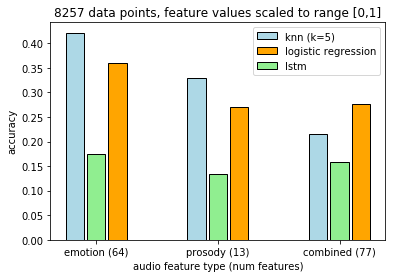

In [82]:
lr = [lr_em_score, lr_pros_score, lr_combo_score]
knn = [knn_em_score, knn_pros_score, knn_combo_score]
lstm = [em_lstm_avg_acc, pros_lstm_avg_acc, combo_lstm_avg_acc]

width = 0.15
offset = 0.05
plt.bar(np.array(range(3))-1.5*width+offset, knn, width, label='knn (k=5)', color=['lightblue']*3, edgecolor=['black']*3)
#plt.bar(np.array(range(3))-width+offset, knn_noshuf, width, label='knn, not shuffled (k=5)', hatch='//', color=['lightblue']*3, edgecolor=['black']*3)
plt.bar(np.array(range(3))+1.5*width-offset, lr, width, label='logistic regression', color=['orange']*3, edgecolor=['black']*3)
plt.bar(np.array(range(3)), lstm, width, label='lstm', color=['lightgreen']*3, edgecolor=['black']*3)

#plt.bar(np.array(range(3))+2*width-offset, logistic_noshuf, width, label='logistic regression, not shuffled', hatch='//', color=['orange']*3, edgecolor=['black']*3)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(range(3), ['emotion (64)', 'prosody (13)', 'combined (77)'])
plt.ylabel('accuracy')
plt.xlabel('audio feature type (num features)')
plt.title('8257 data points, feature values scaled to range [0,1]')
plt.show()

In [ ]:
#seen before! etc test;test and train share prosody features etc

In [174]:
np.unique(np.where(y_skeleton==1)[1], return_counts=True) #pose distrib

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([3864,  146, 1309,  916,  623,  779,   97,  335, 1701,  337]))

# LSTM APPROACH

In [58]:
# correct sign?
def angle_error(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true-y_pred)))

def get_angles_from_onehot(arr):
    out = []
    for i in range(arr.shape[0]):
        notonehot = np.where(arr[i,:]==1)[0][0]
        out.append(angles[notonehot,:])
    return np.array(out)

In [78]:
#clean up
models = []
loss_vals = []
test_accs = []
for i in [X_emotion, np.nan_to_num(X_prosody), np.nan_to_num(X_combined)]:
    input1 = i[:-sum(l_chunks[-1])]
    output1 = y_skeleton[:-sum(l_chunks[-1])]
    scaler = preprocessing.MinMaxScaler().fit(input1)
    input1 = scaler.transform(input1)

    te_input = i[-sum(l_chunks[-1]):]
    te_output = y_skeleton[-sum(l_chunks[-1]):]
    scaler = preprocessing.MinMaxScaler().fit(te_input)
    te_input = scaler.transform(te_input)

    #print()
    #X = i[:-sum(l_chunks[-1])]
    #y = y_skeleton[:-sum(l_chunks[-1])] # normalize!
    #print('asdfasdf',X.shape)

    #scaler = preprocessing.MinMaxScaler().fit(X)
    #X = scaler.transform(X)
    X = input1
    y = output1
    
    #scaler = preprocessing.MinMaxScaler().fit(y)
    #y = scaler.transform(y)

    #losing sequence if shuffle? only chunk at sequnce ends?
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state = 0)
    #te = []
    #tr = []
    #cv.
    #for train_index, test_index in cv.split(X):
    #    tr = train_index
    #    te = test_index

    #X_train = X[tr]
    #y_train = y[tr]
    #X_test = X[te]
    #y_test = y[te]
    #print(X_train.shape,X.shape)
    X_train = X#[np.newaxis,:,:]
    y_train = y#[np.newaxis,:]
    X_test = te_input
    y_test = te_output
    
    n = X_train.shape[0]
    L = 1
    X_train_seq = []
    y_train_seq = []
    X_test_seq=[]
    y_test_seq=[]
    for k in range(n - L + 1):
        X_train_seq.append(X_train[k : k + L])
        y_train_seq.append(y_train[k : k + L])

    n = X_test.shape[0]
    for k in range(n-L+1):
        X_test_seq.append(X_test[k:k+L])
        y_test_seq.append(y_test[k:k+L])

    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    print(X_train_seq.shape,y_train_seq.shape)
    X_test_seq = np.array(X_test_seq)
    y_test_seq = np.array(y_test_seq)
    
    lstm_out = 196
    batch_size = 32
    
    yy = get_angles_from_onehot(y_train_seq)
    yy1 = get_angles_from_onehot(y_test_seq)

    model = Sequential()
    model.add(LSTM(input_dim = X_train.shape[1], output_dim = yy.shape[1], dropout_U = 0.2, dropout_W = 0.2, return_sequences=False))
    #model.add(LSTM(100, return_sequences=False))
    #model.add(Dense(output_dim=yy.shape[1],activation='softmax'))
    model.compile(loss =angle_error, optimizer='adam',metrics = ['accuracy']) #try mse?
    #what else
    print(model.summary())
    
    
    
    a=model.fit(X_train_seq, yy, batch_size = batch_size, epochs = 10, verbose = 2)
    loss_vals.append(a)
    score,acc = model.evaluate(X_test_seq, yy1, verbose = 2, batch_size = batch_size)
    test_accs.append(acc)
    print(acc)
    acc=0
    for ii in range(te_input.shape[0]):
        output_frame_angles = model.predict(te_input[ii:ii+1,np.newaxis,:])
        dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
        output_pose_id = np.argmin(dists_output_to_base_poses)
        #print(output_pose_id,np.where(te_output[ii:ii+1,:]==1)[1][0])
        if output_pose_id == np.where(te_output[ii:ii+1,:]==1)[1][0]:
            acc+=1
    acc/=te_input.shape[0]*1.0
    #score,acc = model.evaluate(X_test_seq, yy1, verbose = 2, batch_size = batch_size)
    #print(score,acc)
    print(acc)
    acc=0
    for ii in range(input1.shape[0]):
        output_frame_angles = model.predict(input1[ii:ii+1,np.newaxis,:])
        dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
        output_pose_id = np.argmin(dists_output_to_base_poses)
        #print(output_pose_id,np.where(te_output[ii:ii+1,:]==1)[1][0])
        if output_pose_id == np.where(output1[ii:ii+1,:]==1)[1][0]:
            acc+=1
    acc/=input1.shape[0]*1.0
    print(acc)
    
    #print(X_test_seq[0:1,:,:].shape)
    #output_frame_angles = model.predict(X_test_seq[0:1,:,:])
    #dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
    #output_pose_id = np.argmin(dists_output_to_base_poses)
    #print(output_pose_id)
    #feed in by dict hmm
    
    models.append(model)
    #momentum?

(10794, 1, 64) (10794, 1, 10)


/Users/anuj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/anuj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 64), units=9, dropout=0.2, recurrent_dropout=0.2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 9)                 2664      
Total params: 2,664
Trainable params: 2,664
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
 - 3s - loss: 36.9786 - acc: 0.0232
Epoch 2/10
 - 2s - loss: 30.5229 - acc: 0.1577
Epoch 3/10
 - 2s - loss: 29.7659 - acc: 0.2150
Epoch 4/10
 - 2s - loss: 29.5891 - acc: 0.2188
Epoch 5/10
 - 2s - loss: 29.5007 - acc: 0.1946
Epoch 6/10
 - 2s - loss: 29.4420 - acc: 0.1957
Epoch 7/10
 - 2s - loss: 29.4013 - acc: 0.1911
Epoch 8/10
 - 2s - loss: 29.3755 - acc: 0.1847
Epoch 9/10
 - 2s - loss: 29.3557 - acc: 0.1787
Epoch 10/10
 - 2s - loss: 29.3349 - acc: 0.1765
0.156424581006
0.1636073423782921
0.14739670187141005
(10794, 1, 13) (10794, 1, 10)


/Users/anuj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 13), units=9, dropout=0.2, recurrent_dropout=0.2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 9)                 828       
Total params: 828
Trainable params: 828
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
 - 3s - loss: 35.9088 - acc: 0.0208
Epoch 2/10
 - 2s - loss: 29.9749 - acc: 0.1521
Epoch 3/10
 - 2s - loss: 29.4471 - acc: 0.1548
Epoch 4/10
 - 2s - loss: 29.3261 - acc: 0.1513
Epoch 5/10
 - 2s - loss: 29.2746 - acc: 0.1438
Epoch 6/10
 - 2s - loss: 29.2442 - acc: 0.1471
Epoch 7/10
 - 2s - loss: 29.2271 - acc: 0.1322
Epoch 8/10
 - 2s - loss: 29.2160 - acc: 0.1446
Epoch 9/10
 - 2s - loss: 29.2080 - acc: 0.1467
Epoch 10/10
 - 2s - loss: 29.2033 - acc: 0.1412
0.0
0.1636073423782921
0.14739670187141005
(10794, 1, 77) (10794, 1, 10)


/Users/anuj/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 77), units=9, dropout=0.2, recurrent_dropout=0.2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 9)                 3132      
Total params: 3,132
Trainable params: 3,132
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
 - 3s - loss: 33.7044 - acc: 0.2128
Epoch 2/10
 - 2s - loss: 29.4543 - acc: 0.1795
Epoch 3/10
 - 2s - loss: 29.3057 - acc: 0.1599
Epoch 4/10
 - 2s - loss: 29.2579 - acc: 0.1543
Epoch 5/10
 - 2s - loss: 29.2310 - acc: 0.1473
Epoch 6/10
 - 2s - loss: 29.2146 - acc: 0.1475
Epoch 7/10
 - 2s - loss: 29.2070 - acc: 0.1431
Epoch 8/10
 - 2s - loss: 29.2017 - acc: 0.1423
Epoch 9/10
 - 2s - loss: 29.1951 - acc: 0.1401
Epoch 10/10
 - 2s - loss: 29.1926 - acc: 0.1465
0.270550678372
0.1636073423782921
0.14739670187141005


In [80]:
em_lstm_avg_acc = np.mean(loss_vals[0].history['acc'])
pros_lstm_avg_acc = np.mean(loss_vals[1].history['acc'])
combo_lstm_avg_acc = np.mean(loss_vals[2].history['acc'])

em_lstm_avg_acc, pros_lstm_avg_acc, combo_lstm_avg_acc

(0.17359644247286954, 0.13346303502304457, 0.15731888086194573)

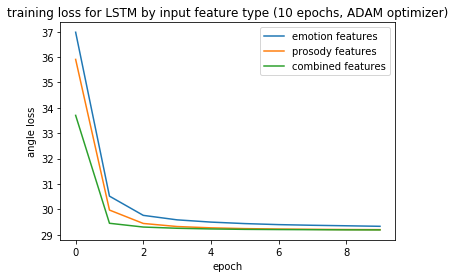

In [81]:
em_lstm_loss = loss_vals[0].history['loss']
pros_lstm_loss = loss_vals[1].history['loss']
combo_lstm_loss = loss_vals[2].history['loss']

plt.plot(em_lstm_loss, label='emotion features')
plt.plot(pros_lstm_loss, label='prosody features')
plt.plot(combo_lstm_loss, label='combined features')
plt.xlabel('epoch')
plt.ylabel('angle loss')
plt.title('training loss for LSTM by input feature type (10 epochs, ADAM optimizer)')
plt.legend()
plt.show()

In [68]:
em_lstm_loss

30.294726039560629

In [465]:
3+4

7

# HUMAN PLAYBACK

In [ ]:
# pick a proportional number of sequential frames from each of the 14 audio chunks etc skel... random spaced etc

In [ ]:
#dist based...angular? or euc?
#CHANGE ALL TO ANGULAR?!
#always rest gesture at end?
#start at base pose hmm

#use time_ms? too small hmm

In [15]:
audio_src='data5'

In [48]:
poses = np.where(y_skel[-sum(l_chunks[-1]):]==1)[1]

pp = []
prev_idx = 0
idx1=-1
dd=[]
for idx, audio_start_end_pair in enumerate(audio_portions_dicts[-1].keys()):
    flag = audio_portions_dicts[-1][audio_start_end_pair]
    duration = round((audio_start_end_pair[1] - audio_start_end_pair[0])/1000)
    #rounding adds extra frames...
    dd.append(duration)
    if flag == 1:
        idx1+=1
        
        n = l_chunks[-1][idx1]
        list_of_poses = poses[prev_idx:prev_idx+n]
        sampled_pose_idxs_relative = sorted(np.random.choice(len(list_of_poses), duration, replace=False))
        sampled_pose_idxs_absolute = [p+prev_idx for p in sampled_pose_idxs_relative]
        for v in poses[sampled_pose_idxs_absolute]:
            pp.append(v)
        prev_idx += n
    else:
        for x in range(duration):
            pp.append(2)

with open('poses_humanreplay_'+audio_src+'.txt', 'w') as f:
    for pose in pp:
        f.write("%s\n" % pose)

In [18]:
len(pp)
#all same at end because not enough long chunks...or silence etc

179

In [629]:
#histograph of poses used hmm
#too many same poses hmm

In [ ]:
#reduce according to audio length...
#store all intermed vals etc
#smallest time interval for nao?, smaller more better movements etc, too fast hmm

In [630]:
#do it that proportion of time not exactly number of times--feed in nn

In [21]:
l_audio_chunks

[175589, 95434, 147725, 113267, 360281, 678998]

# RANDOM PLAYBACK

In [49]:
#do based on pose frequency?

poses = np.random.randint(0, 10, round(l_audio_chunks[-1]/1000))

with open('poses_random_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)

# NO GESTURES PLAYBACK

In [50]:
poses = [2] * round(l_audio_chunks[-1]/1000)

with open('poses_none_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)

# PROSODY PLAYBACK

In [254]:
#get indices of same feature vectors
from scipy.spatial.distance import cdist

existing_vectors = X_prosody[:-sum(l_chunks[-1])]
dists1 = cdist(existing_vectors, existing_vectors, 'euclidean')

same_indices = []
for i in range(dists1.shape[0]):
    same_indices.append(np.where(dists1[i]==0)[0])

# find closest audio feature vector from existing dataset to new audio to get freq of gen!,,,,same in same out etc

#feed num_frames times into NN
num_frames = []

feature_vectors = np.nan_to_num(prosody_vectors)
existing_vectors = np.nan_to_num(X_prosody)

for i in range(feature_vectors.shape[0]):
    dists_new_audio_feature_to_existing_dataset = np.sqrt(np.sum(np.square(feature_vectors[i,:] - existing_vectors),axis=1))
    closest_orig_vec_idx = np.argmin(dists_new_audio_feature_to_existing_dataset)
    #get timing info
    num_frames.append(len(same_indices[closest_orig_vec_idx]))

IndexError: list index out of range

In [227]:
X_prosody.shape

(10107, 13)

In [ ]:
#assuming one second per pose

In [372]:
poses = []

#model = models[1]

features = np.nan_to_num(p)
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)

for i in range(p.shape[0]):
    output_frame_angles = model.predict(features[np.newaxis,i:i+1,:])
    dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
    output_pose_id = np.argmin(dists_output_to_base_poses)
    poses.append(output_pose_id)

with open('poses_prosody_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)
        
print(len(poses),poses)

52 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [516]:
a.predict(np.nan_to_num(p))

(array([7, 0, 0, 7, 2, 0, 0, 7, 0, 0, 0, 3, 7, 0, 7, 7, 7, 0, 0, 8, 7, 7, 0,
        7, 0, 7, 7, 0, 7, 0, 7, 0, 8, 7, 7, 0, 5, 7, 0, 0, 7, 7, 0, 7, 8, 0,
        4, 0, 0, 7, 7, 7, 4, 2, 0, 0, 7, 0, 0, 8, 7, 0, 2, 2, 0, 0, 0, 7, 0,
        0, 7, 7, 3, 7, 7, 0, 0, 2, 3, 0, 3, 8, 7, 0, 7, 0, 7, 2, 8, 3, 8, 0,
        0, 0, 0, 7, 0, 3, 7, 7, 0, 0, 0, 7, 0, 8, 0, 0, 0, 2, 7, 7, 0, 0, 7,
        0, 7, 7, 0, 2, 0, 7, 0, 7, 0, 0, 7, 0, 2, 7, 7, 7, 7, 7, 7]),
 675,
 678998)

In [511]:
poses = []

# take best approach lstm or otherwise and feed in hmm

#angle compare also scale, see output of NN!


a=neighbors.KNeighborsClassifier(n_neighbors=18, leaf_size=100)
input1 = np.nan_to_num(X_prosody[:-sum(l_chunks[-1])])
output1 = np.where(y_skeleton[:-sum(l_chunks[-1])]==1)[1]
a.fit(input1, output1)
#print(a.score(X_emotion[-sum(l_chunks[-1]):], np.where(y_skeleton[-sum(l_chunks[-1]):]==1)[1]))



#model = models[1]

features = np.nan_to_num(X_prosody[-sum(l_chunks[-1]):])
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)
poses = []
idx_new=0
counter=-1
#find closest audio vec in dataset instead of assuming you have in dataset, remove from og dataset what used etc, precaution etc
# should ideally do by sample frames based on dataset stats but need timings to match so using duration
#approach
for idx,k in enumerate(audio_portions_dicts[-1].keys()):
    v=audio_portions_dicts[-1][k]
    if v==1:
        counter+=1
        
        #print(output_frame_angles)
        #rescale output?
        #scaler = preprocessing.MinMaxScaler().fit(output_frame_angles)
        #output_frame_angles = scaler.transform(output_frame_angles)
        #print(output_frame_angles)
        
        for i in range(round((k[1]-k[0])/1000)):
            output_frame_angles = a.predict(features[idx_new:idx_new+1,:])#model.predict(features[np.newaxis,idx_new:idx_new+1,:])
            #dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
            #output_pose_id = np.argmin(dists_output_to_base_poses)
            poses.append(output_pose_id)
        idx_new += l_chunks[-1][counter]
    else:
        poses.append(2)
        
        
        #scale and squash dim!
print(len(poses), l_audio_chunks[-1])

with open('poses_prosody_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)

636 678998


In [512]:
poses

[8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 2,
 2,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,


In [508]:
a=neighbors.KNeighborsClassifier(n_neighbors=18, leaf_size=100)
input1 = X_prosody[:-sum(l_chunks[-1])]
print(input1)
random_inds = np.random.permutation(list(range(input1.shape[0])))
output1 = np.where(y_skeleton[:-sum(l_chunks[-1])]==1)[1]
input1 = input1[random_inds]
print(input1)
output1 = output1[random_inds]
a.fit(input1, output1)
print(a.score(X_emotion[-sum(l_chunks[-1]):], np.where(y_skeleton[-sum(l_chunks[-1]):]==1)[1]))

#a.fit(X_emotion[:-sum(l_chunks[-1])], np.where(y_skeleton[:-sum(l_chunks[-1])]==1)[1])
a.predict(e)

[[ 145.13421631   23.34489059   65.70452157 ...,    1.54056949
   169.16666667  166.18889855]
 [ 145.13421631   23.34489059   65.70452157 ...,    1.54056949
   169.16666667  166.18889855]
 [ 145.13421631   23.34489059   65.70452157 ...,    1.54056949
   169.16666667  166.18889855]
 ..., 
 [ 169.63633728   24.42424202   67.26948868 ...,    1.97960408
   114.84848485  112.89902198]
 [ 169.63633728   24.42424202   67.26948868 ...,    1.97960408
   114.84848485  112.89902198]
 [ 169.63633728   24.42424202   67.26948868 ...,    1.97960408
   114.84848485  112.89902198]]
[[ 184.2086792    22.18695831   62.94304324 ...,    1.90636911
   128.26923077  164.32520704]
 [ 155.79295349   20.68192101   60.51084237 ...,    1.53735371  153.125
   137.87307342]
 [ 186.13644409   33.0322113    78.72292297 ...,    1.41716135
   195.45454545  228.44787097]
 ..., 
 [ 152.14593506   19.78505325   58.97582048 ...,    1.23254362
   276.66666667  325.35450751]
 [ 143.80644226   20.20790863   59.70803822 ...,  

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [278]:
#num frames or timing based approach hmm

In [279]:
#make sure naoqi audio file corresponds etc
#lots of silence, change nums hmm

In [280]:
audio_src='data6'
np.unique(poses,return_counts=True)

(array([0, 1, 2]), array([223,   2,  27]))

# EMOTION PLAYBACK

In [373]:
poses = []

model = models[0]

features = np.nan_to_num(e)
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)

for i in range(p.shape[0]):
    output_frame_angles = model.predict(features[np.newaxis,i:i+1,:])
    dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
    output_pose_id = np.argmin(dists_output_to_base_poses)
    poses.append(output_pose_id)

with open('poses_emotion_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)
        
print(len(poses),poses)

52 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8]


In [275]:
poses = []

model = models[0]

features = np.nan_to_num(X_emotion[-sum(l_chunks[-1]):])
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)
poses = []
idx_new=0
counter=-1
#find closest audio vec in dataset instead of assuming you have in dataset, remove from og dataset what used etc, precaution etc
# should ideally do by sample frames based on dataset stats but need timings to match so using duration
#approach
for idx,k in enumerate(audio_portions_dicts[-1].keys()):
    v=audio_portions_dicts[-1][k]
    if v==1:
        counter+=1
        
        #print(output_frame_angles)
        #rescale output?
        #scaler = preprocessing.MinMaxScaler().fit(output_frame_angles)
        #output_frame_angles = scaler.transform(output_frame_angles)
        #print(output_frame_angles)
        
        for i in range(round((k[1]-k[0])/1000)):
            output_frame_angles = model.predict(features[np.newaxis,idx_new:idx_new+1,:])
            dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
            output_pose_id = np.argmin(dists_output_to_base_poses)
            poses.append(output_pose_id)
        idx_new += l_chunks[-1][counter]
    else:
        poses.append(2)
        
        
        
        #scale and squash dim!
print(len(poses), l_audio_chunks[-1])

with open('poses_emotion_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)

252 261875


In [276]:
np.unique(poses,return_counts=True)

(array([0, 1, 2]), array([200,  25,  27]))

In [12]:
pro1 = []
ids1=[]
emo1=[]
len_chunks=[]
mono_audio_filename = '/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data5/mono_myrecording.wav'
sound_file = AudioSegment.from_wav(mono_audio_filename)
a=range(0,len(sound_file),5*1000)
for idx,i in enumerate(a):
    out_file = '/Users/anuj/coursework_cuboulder/spring_2018/algo_hri/kinect_data/data5/chunks/chunk_{0}.wav'.format(i)
    if idx==len(a)-2:
        chunk=sound_file[i:]
    else:
        chunk = sound_file[i:i+5*1000]
    len_chunks.append(len(chunk))
    print(len(chunk))
    chunk.export(out_file, format="wav")
    prosody_features_filename = get_prosody_features_from_audio(out_file)
    #print(prosody_features_filename)
    with open(prosody_features_filename, 'r') as f:
        prosody_features = list(map(float, f.read()[:-1].split(' ')))
    pro1.append(prosody_features)

    converted_text = get_text_from_speech(out_file)
    emoji_ids, emotion_features = get_emotion_features_from_text(converted_text, out_file)
    ids1.append(emoji_ids)
    emo1.append(emotion_features)
    
    if idx==len(a)-2:
        break

5000


/Users/anuj/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
8267


In [13]:
pro1=np.array(pro1)

In [14]:
emotion_vectors1 = []
for vec in emo1:
    mat = np.zeros((1, 64))
    if len(vec) != 0:
        for idx in range(len(vec)):
            mat += vec[idx]
    emotion_vectors1.append(mat)
emotion_vectors1 = np.array(emotion_vectors1)

In [18]:
combined_features1 = []
for idx,prosody_vec in enumerate(pro1):
    emotion_vec = emotion_vectors1[idx,:,:]
    mat = np.zeros((emotion_vec.shape[0]+1, emotion_vec.shape[1]))
    for i in range(mat.shape[0]-1):
        mat[i,:]=emotion_vec[i,:]
    mat[i+1,:]=np.pad(prosody_vec, (0,mat.shape[1]-len(prosody_vec)), 'constant', constant_values=(0))
    combined_features1.append(mat)
combined_features1 = np.array(combined_features1)
#combined_features1 = combined_features1[:, :emotion_vectors1.shape[1]+pro1.shape[1]]


In [19]:
emotion_vectors1.shape,pro1.shape,combined_features1.shape

((22, 1, 64), (22, 13), (22, 2, 64))

In [ ]:
#what about last x chunk? combine?

In [20]:
p=[]
e=[]
c=[]
for i in range(pro1.shape[0]):
    emotion_v = emotion_vectors1[i]
    prosody_v = pro1[i]
    combined_v = combined_features1[i]

    e.append(emotion_v.flatten())
    p.append(prosody_v)
    c.append(combined_v.flatten())
e = np.array(e)
p = np.array(p)
c = np.array(c)
c=c[:, :e.shape[1]+p.shape[1]]
e.shape,p.shape,c.shape

((22, 64), (22, 13), (22, 77))

In [408]:
poses = []

model = a

features = np.nan_to_num(X_emotion[-sum(l_chunks[-1]):])
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)
poses = []
idx_new=0
counter=-1
#find closest audio vec in dataset instead of assuming you have in dataset, remove from og dataset what used etc, precaution etc
# should ideally do by sample frames based on dataset stats but need timings to match so using duration
#approach
for idx,k in enumerate(audio_portions_dicts[-1].keys()):
    v=audio_portions_dicts[-1][k]
    if v==1:
        counter+=1
        
        #print(output_frame_angles)
        #rescale output?
        #scaler = preprocessing.MinMaxScaler().fit(output_frame_angles)
        #output_frame_angles = scaler.transform(output_frame_angles)
        #print(output_frame_angles)
        
        #same prosody same output hmm
        #if testing and chunking by prosody then doesnt work for emotion hmm
        # for testing, split audio by seconds, more for emotion obviously, get more variation in pose...
        #to make work for current timing idea etc
        for i in range(round((k[1]-k[0])/1000)):
            output_frame_angles = a.predict(features[idx_new:idx_new+1,:])#model.predict(features[np.newaxis,idx_new:idx_new+1,:]) #train every time hmm
            #print(output_frame_angles)
            #dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
            #output_pose_id = np.argmin(dists_output_to_base_poses)
            poses.append(output_frame_angles[0])
        #print('\n')
        idx_new += l_chunks[-1][counter]
    else:
        poses.append(2)
        
        #SAME IN SAME OUT
        
        #scale and squash dim!
print(len(poses), l_audio_chunks[-1])

with open('poses_emotion_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)
        
np.unique(poses,return_counts=True)

252 261875


(array([0, 2, 3, 5, 9]), array([164,  38,  15,  23,  12]))

In [409]:
poses

[2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


# PROSODY+EMOTION PLAYBACK

In [374]:
poses = []

model = models[2]

features = np.nan_to_num(c)
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)

for i in range(p.shape[0]):
    output_frame_angles = model.predict(features[np.newaxis,i:i+1,:])
    dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
    output_pose_id = np.argmin(dists_output_to_base_poses)
    poses.append(output_pose_id)

with open('poses_combined_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)
        
print(len(poses),poses)

52 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [289]:
poses = []

model = models[2]

features = np.nan_to_num(X_combined[-sum(l_chunks[-1]):])
scaler = preprocessing.MinMaxScaler().fit(features)
features = scaler.transform(features)
poses = []
idx_new=0
counter=-1
#find closest audio vec in dataset instead of assuming you have in dataset, remove from og dataset what used etc, precaution etc
# should ideally do by sample frames based on dataset stats but need timings to match so using duration
#approach
for idx,k in enumerate(audio_portions_dicts[-1].keys()):
    v=audio_portions_dicts[-1][k]
    if v==1:
        counter+=1
        
        #print(output_frame_angles)
        #rescale output?
        #scaler = preprocessing.MinMaxScaler().fit(output_frame_angles)
        #output_frame_angles = scaler.transform(output_frame_angles)
        #print(output_frame_angles)
        
        #same prosody same output hmm
        #if testing and chunking by prosody then doesnt work for emotion hmm
        # for testing, split audio by seconds, more for emotion obviously, get more variation in pose...
        #to make work for current timing idea etc
        for i in range(round((k[1]-k[0])/1000)):
            output_frame_angles = model.predict(features[np.newaxis,idx_new:idx_new+1,:]) #train every time hmm
            print(output_frame_angles)
            dists_output_to_base_poses = np.sqrt(np.sum(np.square(output_frame_angles - angles),axis=1))
            output_pose_id = np.argmin(dists_output_to_base_poses)
            poses.append(output_pose_id)
        print('\n')
        idx_new += l_chunks[-1][counter]
    else:
        poses.append(2)
        
        
        
        #scale and squash dim!
print(len(poses), l_audio_chunks[-1])

with open('poses_prosody+emotion_'+audio_src+'.txt', 'w') as f:
    for pose in poses:
        f.write("%s\n" % pose)
        
np.unique(poses,return_counts=True)

[[ 0.75954324  0.26460454  0.30748951  0.22519715  0.26152191 -0.18687975
   0.52609086  0.75803256  0.76036006]]
[[ 0.75954324  0.26460454  0.30748951  0.22519715  0.26152191 -0.18687975
   0.52609086  0.75803256  0.76036006]]
[[ 0.75954324  0.26460454  0.30748951  0.22519715  0.26152191 -0.18687975
   0.52609086  0.75803256  0.76036006]]
[[ 0.75954324  0.26460454  0.30748951  0.22519715  0.26152191 -0.18687975
   0.52609086  0.75803256  0.76036006]]


[[ 0.75933421  0.26332188  0.29656428  0.22593507  0.26237652 -0.22707544
   0.52137446  0.75707036  0.75996971]]
[[ 0.75933421  0.26332188  0.29656428  0.22593507  0.26237652 -0.22707544
   0.52137446  0.75707036  0.75996971]]
[[ 0.75933421  0.26332188  0.29656428  0.22593507  0.26237652 -0.22707544
   0.52137446  0.75707036  0.75996971]]
[[ 0.75933421  0.26332188  0.29656428  0.22593507  0.26237652 -0.22707544
   0.52137446  0.75707036  0.75996971]]
[[ 0.75933421  0.26332188  0.29656428  0.22593507  0.26237652 -0.22707544
   0.5213744

   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139   0.24587339 -0.26648474
   0.53187704  0.7602694   0.76012725]]
[[ 0.75917554  0.28226319  0.30306664  0.2271139

[[ 0.76083565  0.26551971  0.30811122  0.22819674  0.26598838 -0.2304876
   0.5309822   0.760975    0.76121604]]


252 261875


(array([0, 1, 2]), array([223,   2,  27]))

# EVALUATION DATA ANALYSIS

In [130]:
# emotion
statement_1_em = np.mean([2, 2, 2])
statement_2_em = np.mean([4, 3, 2])
statement_3_em = np.mean([2, 2, 1])
statement_4_em = np.mean([3, 2, 3])
statement_5_em = np.mean([2, 4, 4])
statement_6_em = np.mean([3, 2, 3])
statement_7_em = np.mean([2, 2, 2])
statement_8_em = np.mean([2, 2, 3])

statement_1_em1 = np.std([2, 2, 2])
statement_2_em1 = np.std([4, 3, 2])
statement_3_em1 = np.std([2, 2, 1])
statement_4_em1 = np.std([3, 2, 3])
statement_5_em1 = np.std([2, 4, 4])
statement_6_em1 = np.std([3, 2, 3])
statement_7_em1 = np.std([2, 2, 2])
statement_8_em1 = np.std([2, 2, 3])

In [131]:
# human playback
statement_1_human = np.mean([3, 5, 3, 2])
statement_2_human = np.mean([3, 5, 3, 1])
statement_3_human = np.mean([3, 5, 1, 1])
statement_4_human = np.mean([3, 4, 5, 1])
statement_5_human = np.mean([4, 5, 3, 2])
statement_6_human = np.mean([4, 5, 5, 1])
statement_7_human = np.mean([4, 5, 1, 1])
statement_8_human = np.mean([5, 4, 1, 1])

statement_1_human1 = np.std([3, 5, 3, 2])
statement_2_human1 = np.std([3, 5, 3, 1])
statement_3_human1 = np.std([3, 5, 1, 1])
statement_4_human1 = np.std([3, 4, 5, 1])
statement_5_human1 = np.std([4, 5, 3, 2])
statement_6_human1 = np.std([4, 5, 5, 1])
statement_7_human1 = np.std([4, 5, 1, 1])
statement_8_human1 = np.std([5, 4, 1, 1])

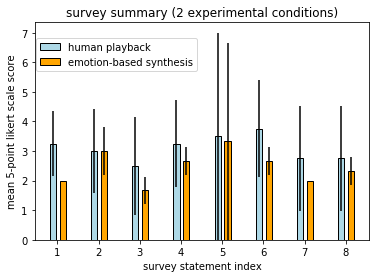

In [137]:
human = [statement_1_human, statement_2_human, statement_3_human, statement_4_human, statement_5_human, statement_6_human, statement_7_human, statement_8_human]
em = [statement_1_em, statement_2_em, statement_3_em, statement_4_em, statement_5_em, statement_6_em, statement_7_em, statement_8_em]

err_human = [statement_1_human1, statement_2_human1, statement_3_human1, statement_4_human1, statement_5_human, statement_6_human1, statement_7_human1, statement_8_human1]
err_em = [statement_1_em1, statement_2_em1, statement_3_em1, statement_4_em1, statement_5_em, statement_6_em1, statement_7_em1, statement_8_em1]

width = 0.15
offset = 0.01
plt.bar(np.array(range(8))-0.8*width+offset, human, width, label='human playback', color=['lightblue']*8, edgecolor=['black']*8, yerr=err_human)
plt.bar(np.array(range(8))+0.8*width+offset, em, width, label='emotion-based synthesis', color=['orange']*8, edgecolor=['black']*8, yerr=err_em)


#plt.bar(np.array(range(3))+2*width-offset, logistic_noshuf, width, label='logistic regression, not shuffled', hatch='//', color=['orange']*3, edgecolor=['black']*3)
plt.legend(bbox_to_anchor=(0.5, 0.95))
plt.xticks(range(8), ['1', '2', '3', '4', '5', '6', '7', '8'])
plt.ylabel('mean 5-point likert scale score')
plt.xlabel('survey statement index')
plt.title('survey summary (2 experimental conditions)')
plt.show()